In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [17]:
from __future__ import print_function, absolute_import

import matplotlib.pyplot as plt

### 1) No-op

Step 1) Vanilla dircol traj. optimization.

In [70]:
from traj.dircol import make_real_dircol_mp

prog, tree = make_real_dircol_mp(expmt="cartpole", seed=1776)

R = 10  # Cost on input "effort".
u = prog.input()
prog.AddRunningCost(R*u[0]**2)

In [111]:
############################################################
# Run this cell to generate some sample trajectories 
# for the supervised learning steps below.
############################################################
ret = prog.Solve()

x_trajectory = prog.ReconstructStateTrajectory()
u_trajectory = prog.ReconstructInputTrajectory()
breaks = np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)
# x_knots = np.hstack([x_trajectory.value(t) for t in breaks])
# u_knots = np.hstack([u_trajectory.value(t) for t in breaks])
x_knots = np.array([x_trajectory.value(t).T[0] for t in breaks])
u_knots = np.array([u_trajectory.value(t).T[0] for t in breaks])
print(x_knots.shape, u_knots.shape)
# assert len(x_knots) == len(u_knots)

# plt.plot(breaks, x_knots[0,:], breaks, x_knots[1,:])

(100, 4) (100, 1)


In [159]:
# print(x_knots[0].shape)
# print(x_trajectory.value(0).shape)
def lin_gen(batch_sz):
    global x_knots
    global u_knots
    n = x_knots.shape[0]
    batch_idxs = np.arange(0, (n)-(n%batch_sz), batch_sz).astype(np.int32)
#     print("batch_idxs: ", batch_idxs)
    for batch_idx in batch_idxs:
        x_data = x_knots[batch_idx:batch_idx+batch_sz,:]
        u_data = u_knots[batch_idx:batch_idx+batch_sz,:]
        yield x_data, u_data
        
# Selects batch_sz random samples, drawn WITH replacement
def rand_gen(batch_sz):
    global x_knots
    global u_knots
    n = x_knots.shape[0]
    idxs = np.random.randint(n, size=batch_sz)
#     print("idxs: ", idxs)
#     print(x_knots[idxs].shape, u_knots[idxs].shape)
    yield x_knots[idxs], u_knots[idxs]
        
for x_data, u_data in rand_gen(100):
    print(x_data.shape, u_data.shape)

(100, 4) (100, 1)


Step 2) Simple supervised learning on (x, u) pairs, with no constraints on policy.

In [ ]:
# SUPER OVERFITTING
import torch

# Define net
from nn_system.NNSystemHelper import FC, MLP
# net = FC(4)
net = MLP(4)


# Define loss and optimizer
import torch.nn as nn
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.3)


# Define training loop
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(my_gen(100), 0):
#     for i, data in enumerate(rand_gen(20), 0):
        # get the inputs
        inputs, labels = data
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 1 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

### 2) GPS

Step 1) dircol traj. optimization using Augmented Lagrangian

In [65]:
import numpy as np

from nn_system.NNSystemHelper import FC, MLP

from traj.dircol import (
    add_running_custom_cost_fn,
    make_pytorch_net_autodiffable,
    make_real_dircol_mp,
)


prog, tree = make_real_dircol_mp(expmt="cartpole", seed=1776)

R = 10  # Cost on input "effort".
u = prog.input()
prog.AddRunningCost(R*u[0]**2)

# Make an auto-differentiable pytorch net function
# net = None
# net = FC(4).double()
net = MLP(4).double()
Pi = make_pytorch_net_autodiffable(net)
lam_t, rho_t = 1, 1 # TODO: use actual lam and rho variables.

def lagrangian(x_t, u_t, t):
    cost = lam_t * (Pi(x_t) - u_t) \
         + rho_t * (Pi(x_t) - u_t).dot(Pi(x_t) - u_t)
    return cost

add_running_custom_cost_fn(prog, lagrangian)

Step 2) Supervised learning on (x, u) pairs, using Augmented Lagrangian

In [ ]:
# SUPER OVERFITTING + Extra L1-sh + L2 terms... weird...
import torch

# Define net
from nn_system.NNSystemHelper import FC, MLP
# net = FC(4)
net = MLP(4)


# Define loss and optimizer
import torch.nn as nn
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.3)


# Define training loop
# TODO: Use actual dual variables here
# TODO: also need to make sure I have individual lam and rho's!!!!
lam, rho = 1, 1
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(my_gen(100), 0):
#     for i, data in enumerate(rand_gen(20), 0):
        # get the inputs
        inputs, labels = data
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        # TODO: Figure out if they want ME or MAE.
#         loss = lam*nn.L1Loss()(outputs, labels) + rho*nn.MSELoss()(outputs, labels)
        loss = lam*sum(outputs - labels)/len(outputs) + rho*nn.MSELoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 1 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

### 3) Interactive Control

Step 1) dircol traj. optimization with L2 augmentation and L2 trajectory distance penalty.

In [206]:
import numpy as np

from nn_system.NNSystemHelper import FC, MLP

from traj.dircol import (
    add_running_custom_cost_fn,
    make_pytorch_net_autodiffable,
    make_real_dircol_mp,
)


prog, tree = make_real_dircol_mp(expmt="cartpole", seed=1776)

R = 10  # Cost on input "effort".
u = prog.input()
prog.AddRunningCost(R*u[0]**2)

# Make an auto-differentiable pytorch net function
# net = None
# net = FC(4).double()
net = MLP(4).double()
Pi = make_pytorch_net_autodiffable(net)
alpha, gamma = 1., 1. # TODO: use actual variables, here.
x_ref = [0]*21 # TODO
def mycost(x_t, u_t, timestep):
    cost = (alpha/2 * (Pi(x_t) - u_t).dot(Pi(x_t) - u_t) 
         + gamma/2 * (x_t - x_ref[timestep]).dot(x_t - x_ref[timestep]),)
    return cost

add_running_custom_cost_fn(prog, mycost)

Step 2) Simple supervised learning on (x, u) pairs, with L2 augmentation and L2 policy distance penalty.

In [ ]:
# SUPER OVERFITTING + L2 + parameter distance metric!
import torch

# Define net
from nn_system.NNSystemHelper import FC, MLP
# net = FC(4)
net = MLP(4)


# Define loss and optimizer
import torch.nn as nn
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.3)

frozen_parameters = [param.clone() for param in net.parameters()]

# Define training loop
# TODO: Use actual dual variables here
# TODO: also need to make sure I have individual lam and rho's!!!!
alpha, gamma = 1., 1.
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(my_gen(100), 0):
#     for i, data in enumerate(rand_gen(20), 0):
        # get the inputs
        inputs, labels = data
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        # TODO: Figure out if they want ME or MAE.
        loss = alpha/2 * nn.MSELoss()(outputs, labels)
        for real, frozen in zip(list(net.parameters()), frozen_parameters):
            loss += gamma/2 * nn.MSELoss()(real, frozen)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 1 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
frozen_parameters = [param.clone() for param in net.parameters()]

# ref = list(net.parameters())
# ref[0][0] = 2012

# print(frozen_parameters[0][0])
frozen_parameters[1]

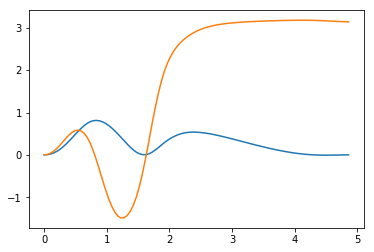

In [207]:
############################################################
# Run this cell to run the code!
############################################################

ret = prog.Solve()

x_trajectory = prog.ReconstructStateTrajectory()
breaks = np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)
x_knots = np.hstack([x_trajectory.value(t) for t in breaks])

plt.plot(breaks, x_knots[0,:], breaks, x_knots[1,:])